## TP2 - Interação e Concorrência


+ Hugo Sousa a76257

In [84]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import *
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

# Descrição 

Cada grupo de estudantes tem um número atribuído e é pretendido utilizar um algoritmo quântico para encontrar o nosso número. O meu grupo de trabalho é o 11 e usarei o algoritmo de Grover para o encontrar numa lista de 8 possíveis. Nesta exemplificação como é numa lista de 8 possíveis foi decidido aplicar 11%8 = 3 então pretendo encontrar a representação binária de 3 que é 011.

# 1 Algoritmo de Grover
## Inicialização
É necessário que todos os estados sejam verificados e portanto é criada uma sobreposição uniforme de todas as possibilidades aplicando um gate Hadamard a cada qubit.


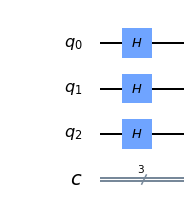

In [48]:
n = 3

cr = ClassicalRegister(n, 'c')
qr = QuantumRegister(n, 'q')

init = QuantumCircuit(qr, cr)
init.h(qr)
init.draw('mpl')

## Construção do oráculo
Pretendemos assinalar o nosso número de grupo mudando a fase da componente $\lvert 011 \rangle$. Para tal optámos por um oráculo de fase que evita usar um qubit auxiliar diminuindo os erros na execução.   
O oráculo de fase consiste em selecionar a componente pretendida ($\lvert 011 \rangle$), aplicar um CCZ e reverter a seleção aplicada anteriormente.   

In [49]:
def ccZ(circuit, c1, c2, t):
    circuit.h(t)
    circuit.ccx(c1, c2, t)
    circuit.h(t)
    
def phase_oracle(circuit, qr):
    circuit.x(qr[2])
    ccZ(circuit, qr[0], qr[1], qr[2])
    circuit.x(qr[2])

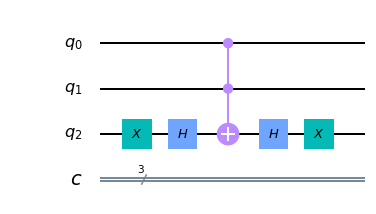

In [50]:
oracle = QuantumCircuit(qr, cr)
phase_oracle(oracle, qr)
oracle.draw('mpl')

## Amplificação

Apesar da mudança de fase, neste momento mantemos as probabilidades iguais para todos casos, o que não nos ajuda muito para o que pretendemos.
O objetivo desta secção é aumentar a probabilidade de obtermos o resultado pretendido.
Para isso, invertemos e aumentamos a amplitude da componente pretendida em torno da média das amplitudes, e simultaneamente reduzimos a amplitude das restantes componentes de forma uniforme.

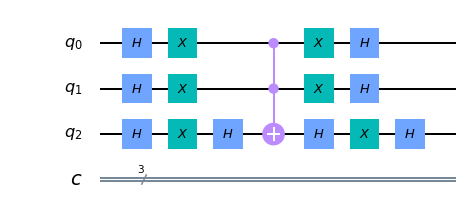

In [51]:
def diffuser(circuit, qr):
    circuit.h(qr)
    circuit.x(qr)
    ccZ(circuit, qr[0], qr[1], qr[2])
    circuit.x(qr)
    circuit.h(qr)
    
amplifier = QuantumCircuit(qr, cr)
diffuser(amplifier, qr)

amplifier.draw('mpl')

## Medição
A medição é a projeção do estado quântico de cada um dos qubits para um bit clássico.
Ao ser medido, cada qubit colapsa para um dos estados possíveis, não sendo mais possível obter o estado quântico inicial.

In [52]:
measure = QuantumCircuit(qr, cr)
measure.measure(qr, cr)

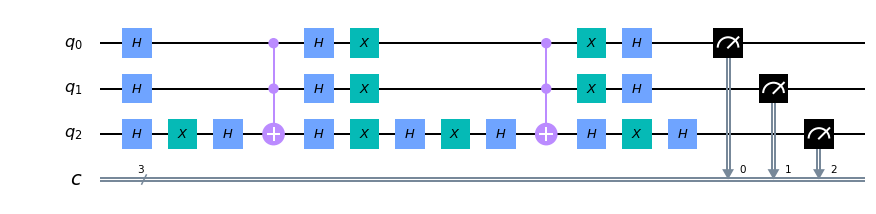

In [53]:
qc_grover = QuantumCircuit()
qc_grover += init
qc_grover += oracle
qc_grover += amplifier
qc_grover += measure

qc_grover.draw('mpl')

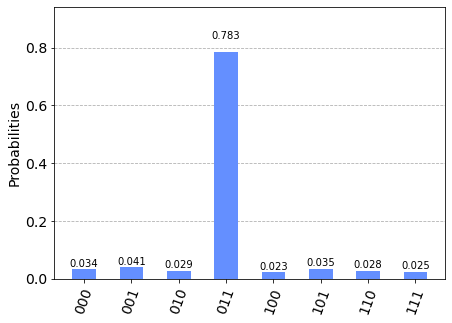

In [54]:
shots=1024
backend = Aer.get_backend("qasm_simulator")
result = execute(qc_grover, backend, shots=shots).result()
counts_sim = result.get_counts(qc_grover)
plot_histogram(counts_sim)

# 2. Simulações de Ruído

In [56]:
from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.load_account()
provider.backends(simulator=False, open_pulse=False)

my_provider_ibmq = IBMQ.get_provider(hub='ibm-q', group='open', project='main') 
backend_device = my_provider_ibmq.get_backend('ibmq_16_melbourne')
coupling_map = backend_device.configuration().coupling_map
noise_model = NoiseModel.from_backend(backend_device)

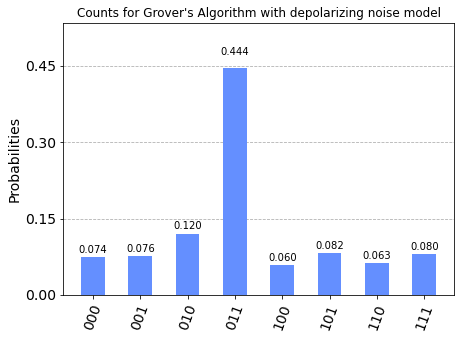

In [59]:
basis_gates = noise_model.basis_gates

result_noise = execute(qc_grover, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(qc_grover)

plot_histogram(counts_noise, title="Counts for Grover's Algorithm with depolarizing noise model")

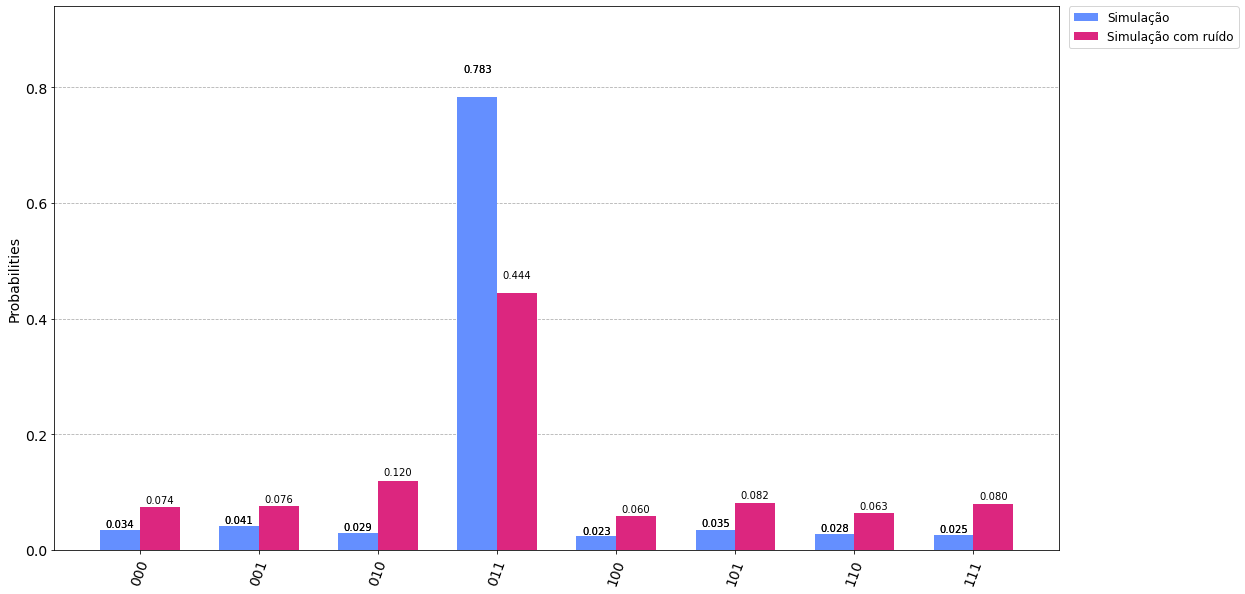

In [81]:
plot_histogram([counts_sim, counts_noise], legend=[ "Simulação", "Simulação com ruído" ], figsize=(18, 10))

# 3. Correr num computador quântico

In [63]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [64]:
import qiskit.tools.jupyter

%qiskit_backend_overview

In [65]:
backend_device = provider.get_backend('ibmqx2')
print("Running on: ", backend_device)

Running on:  ibmqx2


In [66]:
backend_device

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

In [68]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [70]:
job_r = execute(qc_grover, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 5eefdd9557160100198ff788


In [71]:
job_get=backend_device.retrieve_job(jobID_r)

job_get.error_message()

In [73]:
job_get=backend_device.retrieve_job(jobID_r)

result_r = job_get.result()
counts_run = result_r.get_counts(qc_grover)

In [74]:
#ibmq_16_melbourne 1 times the oracle:
job_get=backend_device.retrieve_job(jobID_r)

result_r = job_get.result()
counts_run = result_r.get_counts(qc_grover)

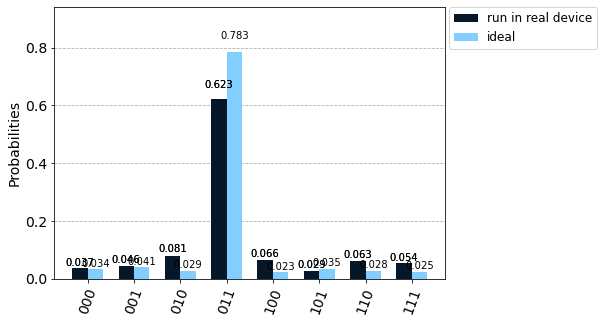

In [75]:
plot_histogram([counts_run, counts_sim ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

# 4 Mitigação de erros com o Ignis

In [82]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                CompleteMeasFitter, TensoredMeasFitter)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

NameError: name 'complete_meas_cal' is not defined